#### Imports

In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
from tqdm import tqdm

#### Autocrop and renaming

(3000, 4000, 3)


(-0.5, 3624.5, 2325.5, -0.5)

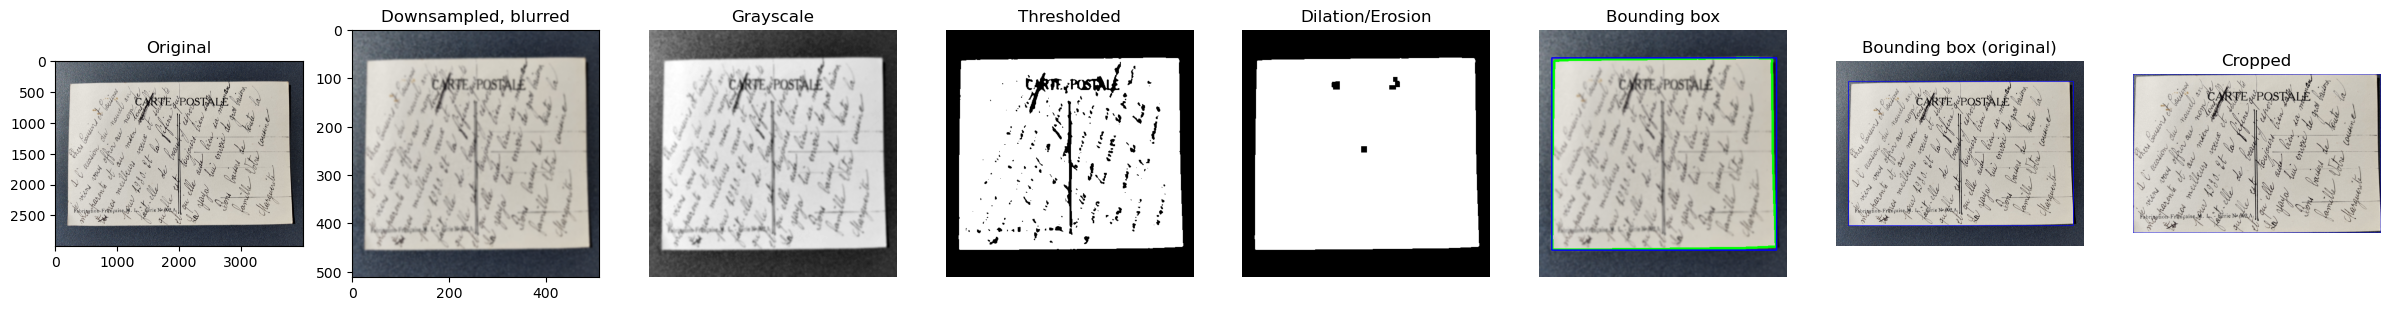

In [83]:
fig, axes = plt.subplots(1, 8, figsize=(30, 5))
    
# Plot random image from raw folder
img_list = os.listdir('raw')
i = np.random.randint(0, len(img_list))
orig_img = cv.imread('raw/' + img_list[i])
print(orig_img.shape)
orig_shape = orig_img.shape

axes[0].imshow(cv.cvtColor(orig_img, cv.COLOR_BGR2RGB))
axes[0].set_title('Original')

# Downsample to (512, 512)
img = cv.resize(orig_img, (512, 512))
# Gaussian blur
img = cv.GaussianBlur(img, (9, 9), 0)

axes[1].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
axes[1].set_title('Downsampled, blurred')

# Convert to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
axes[2].imshow(gray, cmap='gray')
axes[2].set_title('Grayscale')
axes[2].axis('off')

# Thresholding
_, thresh = cv.threshold(gray, 150, 255, cv.THRESH_BINARY)
axes[3].imshow(thresh, cmap='gray')
axes[3].set_title('Thresholded')
axes[3].axis('off')

# Dilation and erosion
kernel = np.ones((5, 5), np.uint8)
dilated = cv.dilate(thresh, kernel, iterations=2)
eroded = cv.erode(dilated, kernel, iterations=2)
axes[4].imshow(eroded, cmap='gray')
axes[4].set_title('Dilation/Erosion')
axes[4].axis('off')

# Find contours
contours, _ = cv.findContours(eroded, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# Find largest contour
max_area = 0
max_contour = None
for contour in contours:
    area = cv.contourArea(contour)
    if area > max_area:
        max_area = area
        max_contour = contour
# Draw contour
cv.drawContours(img, [max_contour], -1, (0, 255, 0), 3)

# Bounding box rectangle
x, y, w, h = cv.boundingRect(max_contour)
cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
axes[5].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
axes[5].set_title('Bounding box')
axes[5].axis('off')

# Back to original shape
x = int(x * orig_shape[1] / 512)
y = int(y * orig_shape[0] / 512)
w = int(w * orig_shape[1] / 512)
h = int(h * orig_shape[0] / 512)

cv.rectangle(orig_img, (x, y), (x + w, y + h), (255, 0, 0), 10)
axes[6].imshow(cv.cvtColor(orig_img, cv.COLOR_BGR2RGB))
axes[6].set_title('Bounding box (original)')
axes[6].axis('off')

# Crop to bounding box
crop = orig_img[y:y+h, x:x+w]
axes[7].imshow(cv.cvtColor(crop, cv.COLOR_BGR2RGB))
axes[7].set_title('Cropped')
axes[7].axis('off')

In [40]:
def crop_img(img_path):
    orig_img = cv.imread(img_path)
    orig_shape = orig_img.shape
    img = cv.resize(orig_img, (512, 512))
    img = cv.GaussianBlur(img, (9, 9), 0)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, 150, 255, cv.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv.dilate(thresh, kernel, iterations=2)
    eroded = cv.erode(dilated, kernel, iterations=2)
    contours, _ = cv.findContours(eroded, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    max_area = 0
    max_contour = None
    for contour in contours:
        area = cv.contourArea(contour)
        if area > max_area:
            max_area = area
            max_contour = contour
    x, y, w, h = cv.boundingRect(max_contour)
    x = int(x * orig_shape[1] / 512)
    y = int(y * orig_shape[0] / 512)
    w = int(w * orig_shape[1] / 512)
    h = int(h * orig_shape[0] / 512)
    return orig_img[y:y+h, x:x+w]


In [41]:
# Rename and crop images
os.makedirs('cropped', exist_ok=True)

for i, img in tqdm(enumerate(os.listdir('raw')), total=len(os.listdir('raw'))):
    i+=1
    if (i)%2 == 1:
        img_name = f"cropped/{(i+1)//2}_recto_cropped.jpg"
    else:
        img_name = f"cropped/{(i+1)//2}_verso_cropped.jpg"
    crop = crop_img(f'raw/{img}')
    cv.imwrite(img_name, crop)

100%|██████████| 181/181 [00:42<00:00,  4.21it/s]


#### Text recognition

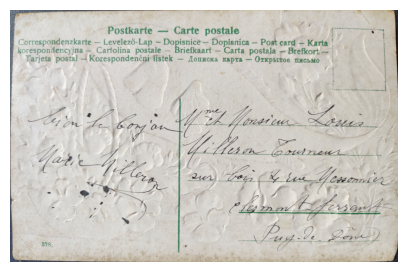

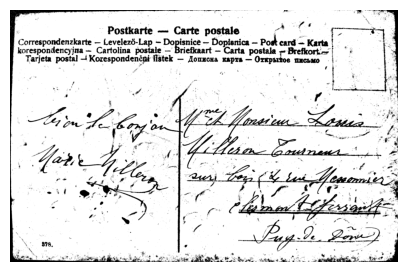

In [28]:
# Open a random verso cropped image
img_list = os.listdir('cropped')
i = np.random.randint(0, len(img_list)//2)
img_path = f'cropped/{i+1}_verso_cropped.jpg'
img = cv.imread(img_path)
plt.figure(figsize=(5, 5))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Grey scale, threshold to binary
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
_, thresh = cv.threshold(gray, 175, 255, cv.THRESH_BINARY)
# Small blur to remove noise
blurred = cv.GaussianBlur(thresh, (5, 5), 0)
# Noise removal: erosion and dilation
kernel = np.ones((3, 3), np.uint8)
dilated = cv.dilate(blurred, kernel, iterations=1)
ocr_input = cv.erode(dilated, kernel, iterations=2)
plt.figure(figsize=(5, 5))
plt.imshow(ocr_input, cmap='gray')
plt.axis('off')
plt.show()


In [30]:
def ocr_preprocess(img_path):
    img = cv.imread(img_path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, 175, 255, cv.THRESH_BINARY)
    blurred = cv.GaussianBlur(thresh, (5, 5), 0)
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv.dilate(blurred, kernel, iterations=1)
    ocr_input = cv.erode(dilated, kernel, iterations=2)
    return ocr_input

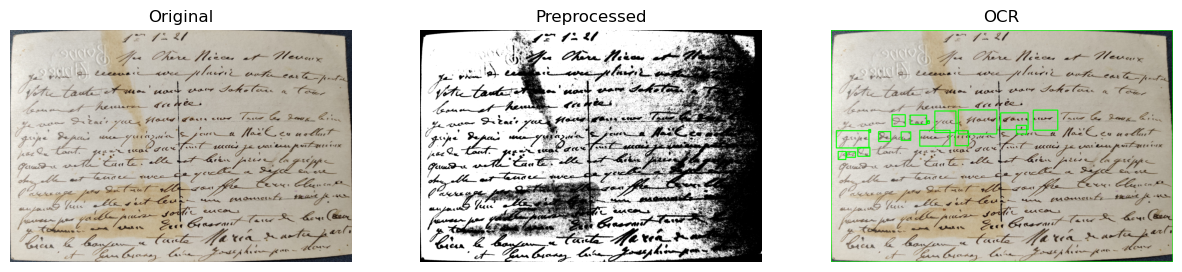

. ae a at e —_
Sig = 7 £7 te
‘ ’ ‘ 4 of eg / ww, ‘ i Wht * barr ” A :
AS I) 7 Care. Pf ’ ey te
ey YS (Fé & Gay eft AG et aoe
eon (i rT
wi n a “. 4 i c oe nad PEP og St hg i oT a a is oy ss Fg
t Yada =e aot J 5 Bae: 7 ea
Z Altea cael on Sohctar. in Tome
me ee 6.4 6 ES ee gee ‘ ee
oe — << saan Stace ccs flex Hd (ag Ss hen ee J rie: Sid be
4 . * : : cdg’ Gists eee: Sma to | eo
i ' F4u: aaa Sine “ nd wv ’ Ce! omer
a Ae De pci: cA Bs WR aS tae 0A mea ig ee
mn 2 se t ie ee f ger. age 2% i RZ IRE nang ae
, g pf eeoteee. |S execu o i ie Series ES es
(etc Hod yep reac (™ ape oe t< acta
Psd ~ = es cas nn Oth — Sy ES Py, eS er
< » a b, y ih os iy si aT Ay ’ dene os ies poe 0 cart
f e¢ Lu fe OY Le . i okia AE: f ¢. Me ” Be sa eho hge ae
‘ Ll ; Naa Gs Zales: Be > ees je
C ee an a ae J: Sl ae
y4 at IPS , E £3 o ea Pe wh Thy F: so > pt Fa i ia ok to nit Mr . ns — ~ oa * _ Sg
Cus & so rm a naa as, due eK S ay Rng) am, Y f- isthe : . 8 LZ 4 " =. 5 o a a a: ne 3 fir" 2
a+ % ™ 2 at sha Eg ’ Ss: ‘ me bese

In [38]:
import pytesseract
from pytesseract import Output


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

img_list = os.listdir('cropped')
i = np.random.randint(0, len(img_list)//2)
img_path = f'cropped/{i+1}_verso_cropped.jpg'
img = cv.imread(img_path)

axes[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')

ocr_input = ocr_preprocess(img_path)

axes[1].imshow(ocr_input, cmap='gray')
axes[1].set_title('Preprocessed')
axes[1].axis('off')

tesseract_path = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
pytesseract.pytesseract.tesseract_cmd = tesseract_path

# OCR
ocr_output = ocr_input.copy()
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(ocr_input, config=custom_config)

# OCR with boxes
d = pytesseract.image_to_data(ocr_output, output_type=Output.DICT)
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 0:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        ocr_output = cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 10)

axes[2].imshow(cv.cvtColor(ocr_output, cv.COLOR_BGR2RGB))
axes[2].set_title('OCR')
axes[2].axis('off')
plt.show()

print(text)
